In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kundan7678234191","key":"679a995bc749278c728562c868602d5b"}'}

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.95G/1.96G [01:10<00:00, 35.9MB/s]
100% 1.96G/1.96G [01:10<00:00, 29.8MB/s]


In [ ]:
!unzip /content/100-bird-species.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/WHITE TAILED TROPIC/120.jpg  
  inflating: train/WHITE TAILED TROPIC/121.jpg  
  inflating: train/WHITE TAILED TROPIC/122.jpg  
  inflating: train/WHITE TAILED TROPIC/123.jpg  
  inflating: train/WHITE TAILED TROPIC/124.jpg  
  inflating: train/WHITE TAILED TROPIC/125.jpg  
  inflating: train/WHITE TAILED TROPIC/126.jpg  
  inflating: train/WHITE TAILED TROPIC/127.jpg  
  inflating: train/WHITE TAILED TROPIC/128.jpg  
  inflating: train/WHITE TAILED TROPIC/129.jpg  
  inflating: train/WHITE TAILED TROPIC/130.jpg  
  inflating: train/WHITE TAILED TROPIC/131.jpg  
  inflating: train/WHITE TAILED TROPIC/132.jpg  
  inflating: train/WHITE TAILED TROPIC/133.jpg  
  inflating: train/WHITE TAILED TROPIC/134.jpg  
  inflating: train/WHITE TAILED TROPIC/135.jpg  
  inflating: train/WHITE TAILED TROPIC/136.jpg  
  inflating: train/WHITE TAILED TROPIC/137.jpg  
  inflating: train/WHITE TAILED TROPIC/138.jpg  
  inflating: train

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

from pathlib import Path
from PIL import Image

In [ ]:
data = pd.read_csv("/content/birds.csv")
data["class id"] = data["class id"].astype(int)

train_df = data[data["data set"]=="train"]
test_df = data[data["data set"]=="test"]
val_df = data[data["data set"]=="valid"]

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)
data.tail(3)

(84635, 5)
(2625, 5)
(2625, 5)


,class id,filepaths,labels,data set,scientific name
89882,524,valid/BLACK BREASTED PUFFBIRD/1.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89883,524,valid/BLACK BREASTED PUFFBIRD/2.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89884,524,valid/BLACK BREASTED PUFFBIRD/5.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS


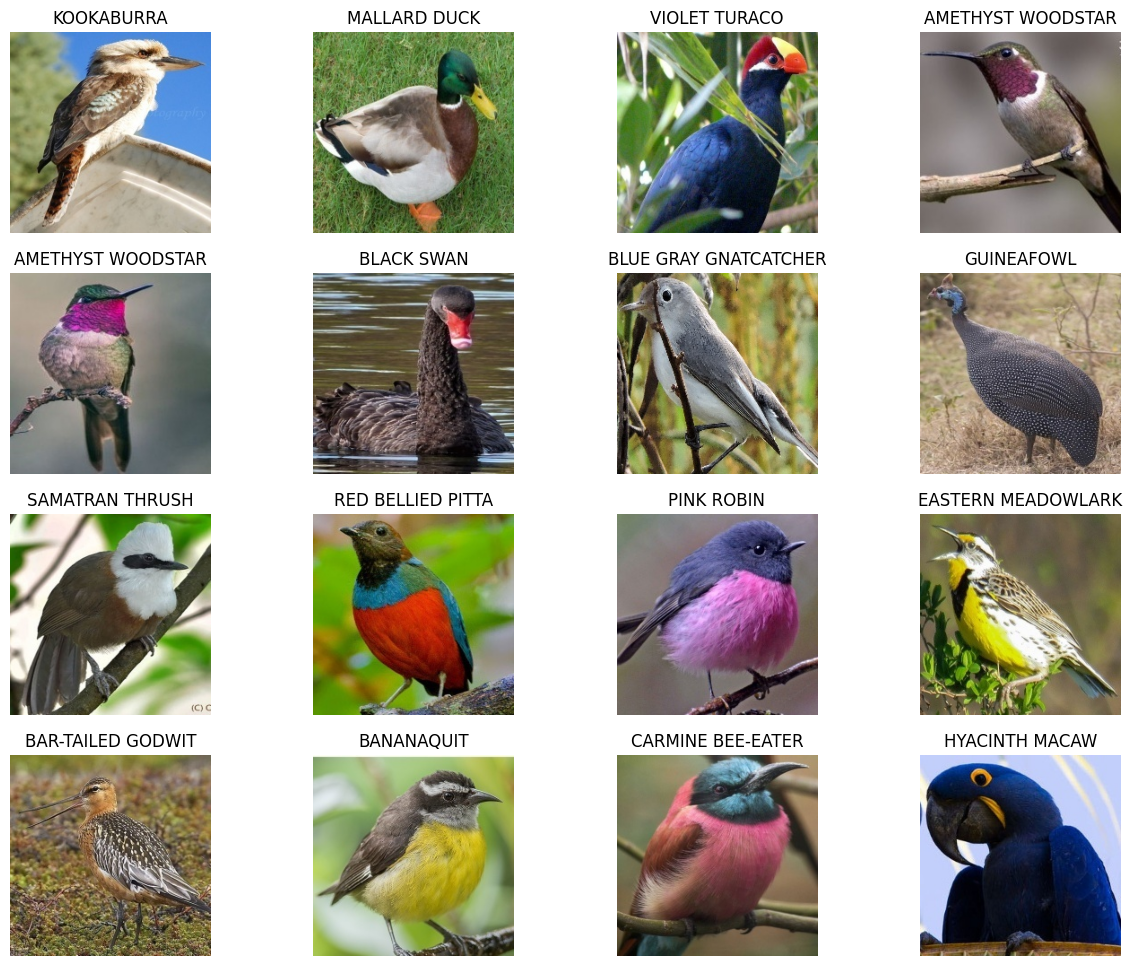

In [ ]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['filepaths']
    image = Image.open("/content/"+image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [ ]:
%%time

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

train_datagen = ImageDataGenerator(rotation_range = 10,
#                                    rescale = 1./255., # pretrained model already has rescale
#                                    width_shift_range = 0.2,
#                                    height_shift_range = 0.2,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator() # rescale = 1./255.

# Split the data into three categories.
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/content/",
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="/content/",
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="/content/",
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 84480 validated image filenames belonging to 524 classes.
Found 2620 validated image filenames belonging to 524 classes.
Found 2620 validated image filenames belonging to 524 classes.
CPU times: user 551 ms, sys: 235 ms, total: 786 ms
Wall time: 813 ms


In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

43941136/43941136 [==============================] - 2s 0us/step


In [ ]:
num_classes = len(set(train_images.classes))

# Data Augmentation Step
# augment = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal"),
#   layers.experimental.preprocessing.RandomRotation(0.15),
# #   layers.experimental.preprocessing.RandomZoom(0.1),
# #   layers.experimental.preprocessing.RandomContrast(0.1),
# ], name='AugmentationLayer')

inputs = layers.Input(shape = (224,224,3), name='inputLayer')
# x = augment(inputs)
pretrain_out = pretrained_model(inputs, training = False)
x = layers.Dense(num_classes, name='outputLayer')(pretrain_out)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 10 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 outputLayer (Dense)         (None, 524)               805388    
                                                                 
 activationLayer (Activation  (None, 524)              0         
 )                                                               
                                                                 
Total params: 11,588,923
Trainable params: 805,388
Non-trainable params: 10,783,535
_________________________________________________________________
None
Epoch 1/20
2640/2640 [==============================] - 1106s 409ms/step - loss: 1.3608 - accuracy: 0.71

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'red', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

### **FINE-TUNING MODEL**

In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')


In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'red', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

In [ ]:
report = classification_report(y_true, y_pred, target_names=test_images.class_indices.keys(), output_dict=True)
for key, value in report.items():
    if key == 'accuracy':
        continue
    report[key] = report[key]["f1-score"]

F1 = pd.DataFrame({"Classes":list(report.keys()),
                   "F1-Scores":list(report.values())}).sort_values("F1-Scores", ascending=False).tail(30)


fig, ax = plt.subplots(figsize = (15,20))
plt.barh(F1["Classes"], F1["F1-Scores"])
# plt.ylim(-1,101)
plt.xlabel("F1-Scores")
plt.ylabel("Food Classes")
plt.title("F1-Scores across WORST 30 Classes")
plt.gca().invert_yaxis()
for i, val in enumerate(round(F1["F1-Scores"],3)):
    ax.text(val, i + .25, str(val), color='red');

In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

#Print the most confident errors

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open("/kaggle/input/100-bird-species/"+image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()